# Yelp Restaurant Photos Classification

Yelp held a photo classification competition on Kaggle two years ago. It asked Kagglers
to build a model that automatically tags user-uploaded photos with multiple labels, nine
labels to be exact. In this capstone project, I would be working on designing and
building a Convolutional Neural Network to try to achieve or better the highest
benchmark score. The goal of this project is to assign a set of labels to each photo
correctly. 

## Import Libaries

In [1]:
import os
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from sklearn.datasets import load_files       
from sklearn.model_selection import train_test_split
from PIL import ImageFile
from matplotlib import pyplot as plt


%matplotlib inline

Using TensorFlow backend.


## Import Datasets

**test_photo_to_biz.csv.tgz** and **train_photo_to_biz_ids.csv.tgz** contain the mapping
from each photo to its associated business ID. In other words, this mapping allows a
business to have more than one pictures, and we're able to tell which photos belong to
which store.

**test_photos.tgz** and **train_photos.tgz** contain the actual photos. Photo ID is in each
photo's file name. All the images are user-uploaded, meaning they are non-uniform in
sizes and color images.

**train.csv.tgz** contains each business ID with its associated correct/truth labels. There are
2000 distinct businesses.

In [2]:
# load train and validation datasets
def load_dataset(path, photos_to_biz, labels):
    # get filenames
    processed_filenames, processed_labels = [], []
    filenames = os.listdir(path=path)
    for filename in filenames:
        # remove filename that contains underscore
        if '_' not in filename:
            processed_filenames.append(filename)
    
    # delete this line when actually training!!!!!!!!!!!!!!!! only test code works for now
    processed_filenames = processed_filenames[:10000]
    
    # get each photo's target labels
    for filename in tqdm(processed_filenames):
        bus_id = photos_to_biz.query('train_photo_id=={}'.format(filename.split(".", 1)[0]))['business_id']
        this_labels = labels.query("business_id=={}".format(bus_id.iloc[0]))['labels'].iloc[0]
        
        tmp_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        if isinstance(this_labels, float) and math.isnan(this_labels):
            # empty cell
            pass
        else:
            # multiple labels
            this_labels = this_labels.split(" ")
            for label in this_labels:
                tmp_labels[int(label)] = 1

        processed_labels.append(tmp_labels)
    
    X_train, X_validation, y_train, y_validation = train_test_split(np.array(processed_filenames), 
                                                                    np.array(processed_labels), 
                                                                    test_size = 0.2, 
                                                                    random_state = 0)
    
    return X_train, X_validation, y_train, y_validation

img_folder = 'C:/Users/I-Chun Liu/Documents/Local_Code/final_project/data'

test_photos_to_biz = pd.read_csv(img_folder + '/test_photo_to_biz.csv.tgz', compression='gzip', sep=',')
test_photos_to_biz.columns = ['test_photo_id', 'business_id']

train_photo_to_biz_ids = pd.read_csv(img_folder + '/train_photo_to_biz_ids.csv.tgz', compression='gzip', sep=',')
train_photo_to_biz_ids.columns = ['train_photo_id', 'business_id']

train_labels = pd.read_csv(img_folder + '/train.csv.tgz', compression='gzip', sep=',')
train_labels.columns = ['business_id', 'labels']

X_train, X_validation, y_train, y_validation = load_dataset(img_folder + '/train_photos', train_photo_to_biz_ids, train_labels)

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.08it/s]


In [3]:
# show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(y_validation.shape[0]))

Training set has 8000 samples.
Validation set has 2000 samples.


## Pre-process Data

In [4]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_filenames):
    list_of_tensors = [path_to_tensor(img_folder + '/train_photos/' + img_filename) for img_filename in tqdm(img_filenames)]
    return np.vstack(list_of_tensors)


train_tensors = paths_to_tensor(X_train).astype('float32')/255
validation_tensors = paths_to_tensor(X_validation).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 723.13it/s]


In [5]:
print("Train tenors size: {}".format(train_tensors.shape))
print("Validation tenors size: {}".format(validation_tensors.shape))

Train tenors size: (8000, 224, 224, 3)
Validation tenors size: (2000, 224, 224, 3)


### Image Augmentations

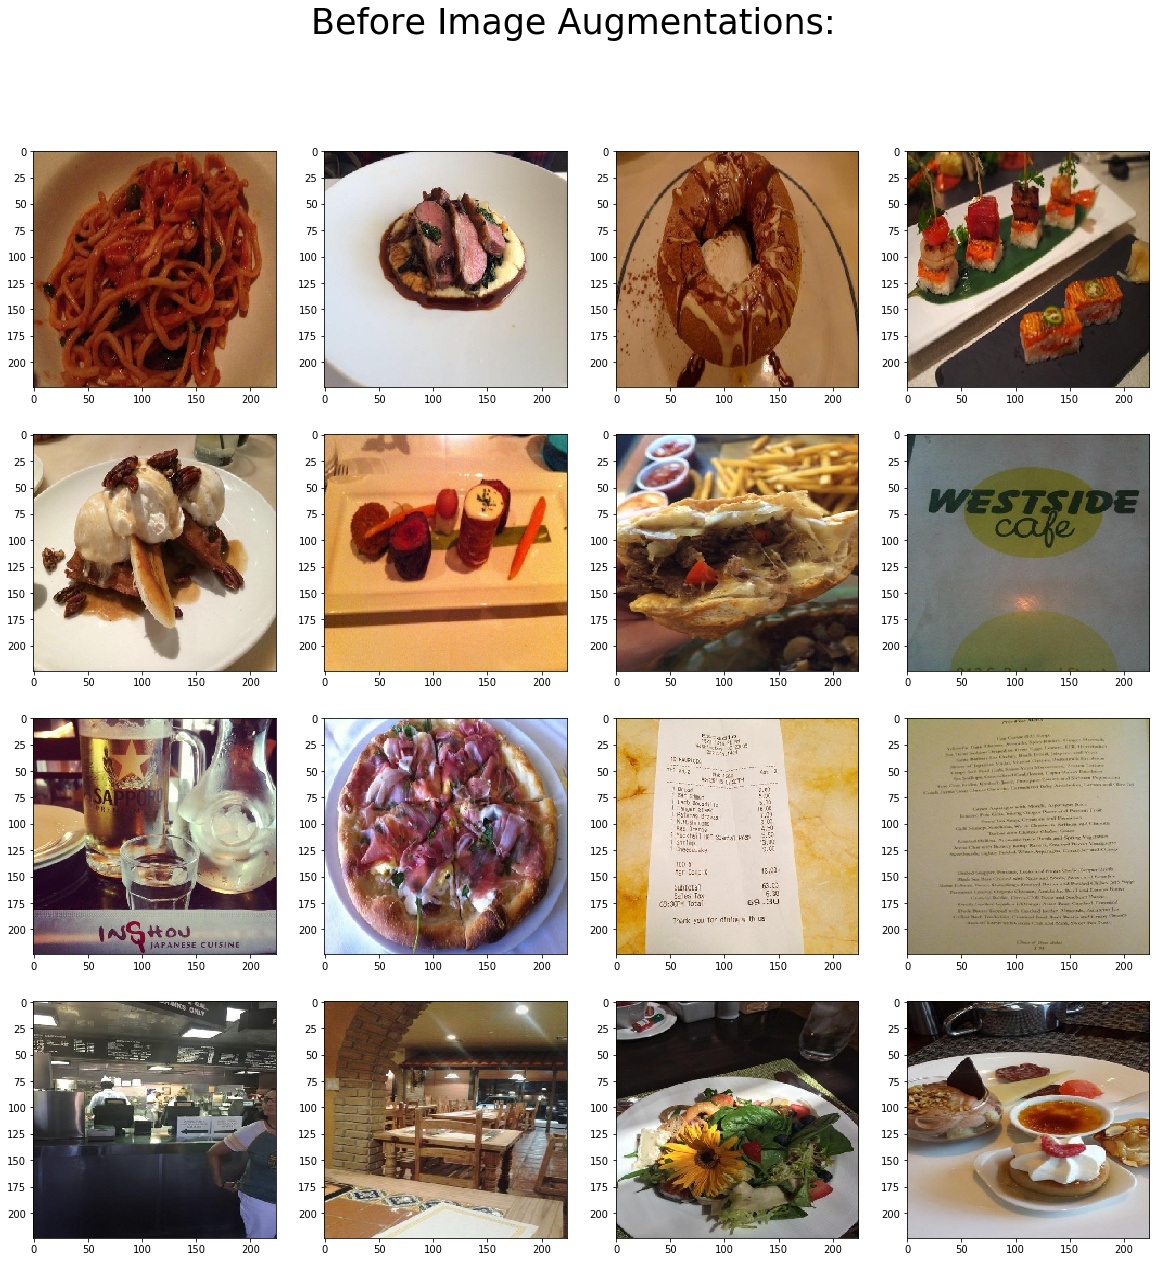

In [6]:
f1, subplots_array_before = plt.subplots(4,4, figsize=(20, 20))
f1.suptitle('Before Image Augmentations:', fontsize=35)
for i in range(0, 16):
    row, col = 0, 0
    for i in range(0, 16):
        if col == 4:
            col = 0
            row += 1

        subplots_array_before[row, col].imshow(train_tensors[i], interpolation='nearest', aspect='auto')
        col += 1

    # show the plot
    plt.show()
    break

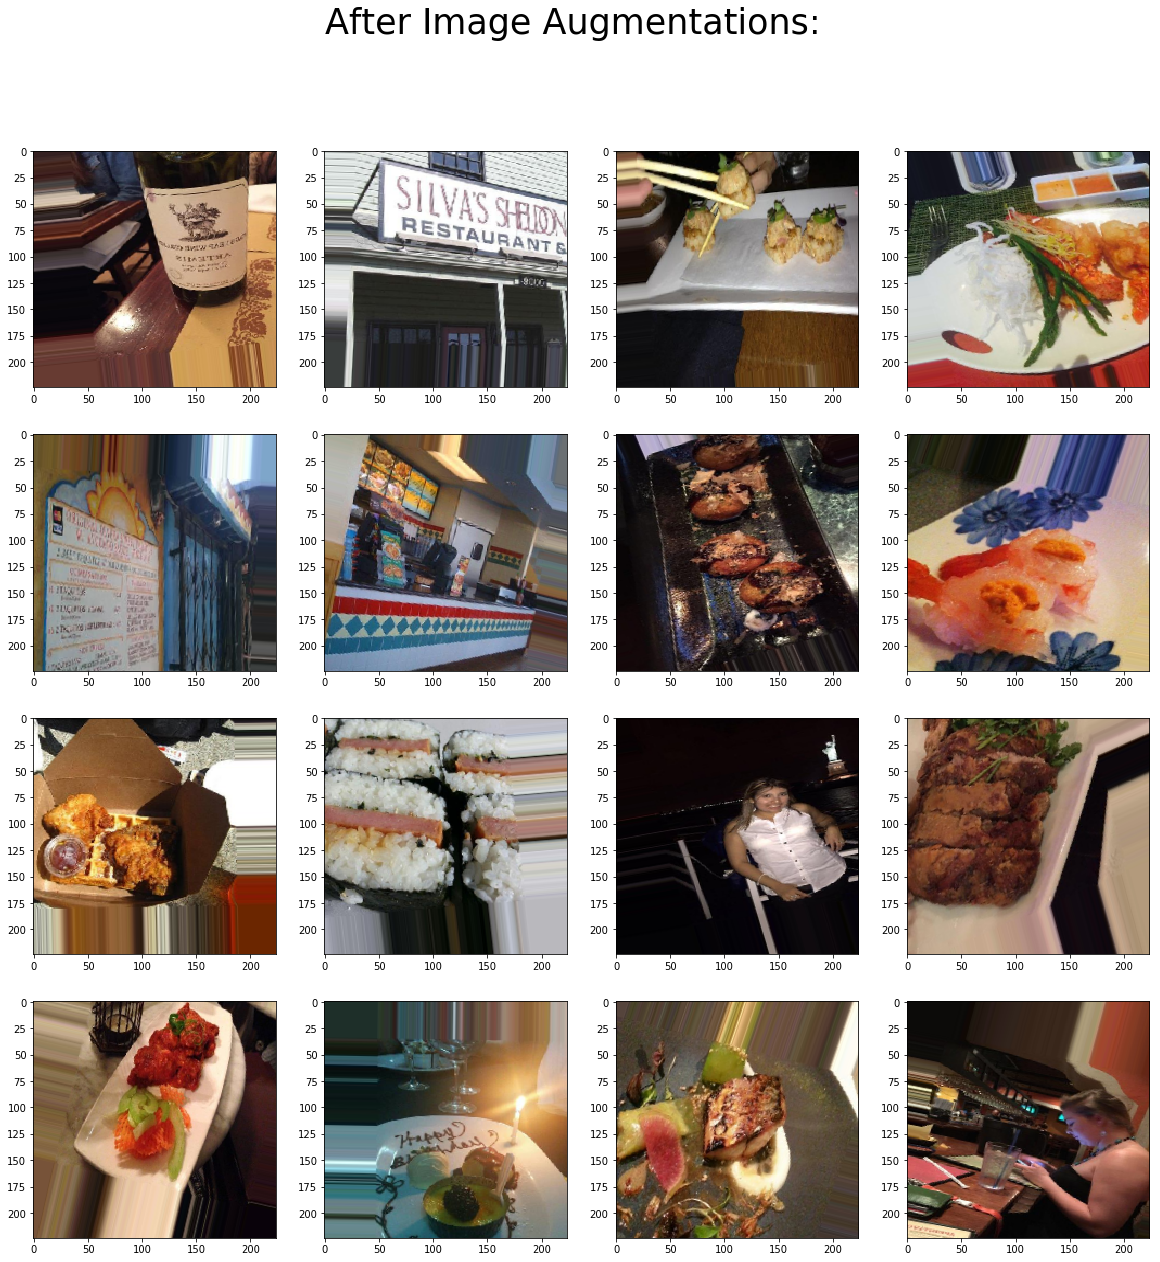

In [7]:
# perform image augmentations
datagen_train = image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

datagen_validation = image.ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.05,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

datagen_train.fit(train_tensors)
datagen_validation.fit(validation_tensors)


f2, subplots_array_after = plt.subplots(4,4, figsize=(20, 20))
f2.suptitle('After Image Augmentations:', fontsize=35)
for X_batch in datagen_train.flow(train_tensors):
    row, col = 0, 0
    for i in range(0, 16):
        if col == 4:
            col = 0
            row += 1

        subplots_array_after[row, col].imshow(X_batch[i], interpolation='nearest', aspect='auto')
        col += 1

    # show the plot
    plt.show()
    break

In [8]:
batch_size = 32

# package training data/labels
train_generator = datagen_train.flow(train_tensors, y_train, batch_size=batch_size)
validation_generator = datagen_validation.flow(validation_tensors, y_validation, batch_size=batch_size)

# initilize pre-trained model: ResNet50 
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# show model summary
ResNet50_model.summary()

c:\users\i-chun liu\anaconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

activation_10 (Activation)      (None, 56, 56, 256)  0           add_3[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________

In [ ]:
# ouput dimensions from pre-trained model
pretrained_x_dim, pretrained_y_dim, pretrained_z_dim = 7, 7, 2048

# number of output labels
num_output_labels = 9


def extractBottleneckFeatures(generator, num_images):
    # initilizations of variables use to feature extractions
    i = 0 

    features = np.zeros(shape=(num_images, pretrained_x_dim, pretrained_y_dim, pretrained_z_dim))
    labels = np.zeros(shape=(num_images, num_output_labels))

    # extract bottleneck features
    for inputs_batch, labels_batch in tqdm(generator):
        features_batch = ResNet50_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1

        if i * batch_size >= num_images:
            break

    # reshape features into a vector
    features = np.reshape(features, (num_images, pretrained_x_dim * pretrained_y_dim * pretrained_z_dim))
    
    return features, labels


train_features, train_labels = extractBottleneckFeatures(train_generator, train_tensors.shape[0])
validation_features, validation_labels = extractBottleneckFeatures(validation_generator, validation_tensors.shape[0])

print("Train features shape: {}".format(train_features.shape))
print("Validation features shape: {}".format(validation_features.shape))

  8%|███████                                                                             | 21/250 [01:58<20:24,  5.35s/it]

In [ ]:
epochs = 20

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=pretrained_x_dim * pretrained_y_dim * pretrained_z_dim))
model.add(Dense(1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_features,validation_labels), verbose=2)

# features = model.predict(train_tensors)

# ResNet50_model = Sequential()
# ResNet50_model.add(GlobalAveragePooling2D(input_shape=features.shape[1:]))
# ResNet50_model.add(Dense(133, activation='softmax'))

# ResNet50_model.summary()

# References
1. How to use pretrained model in Keras: https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/
